In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# airline passengers datasets to build intuition on how arima works
# --> return to looking at stocks
# easier with airline passengers datasets to understand arima behaviour
# with stocks = difficult to tell if there's a problem due to bad settings or error in stock prices

df = pd.read_csv(r"C:\Users\Emilie Berger\Downloads\airline_passengers.csv", index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

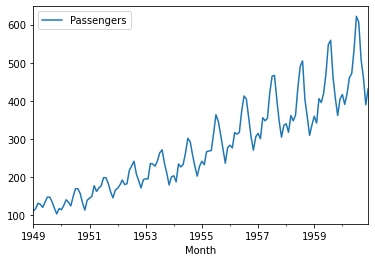

In [3]:
df.plot()

In [4]:
# 1st difference in data

df['1stdiff'] = df['Passengers'].diff()
df.head()

,Passengers,1stdiff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


<AxesSubplot:xlabel='Month'>

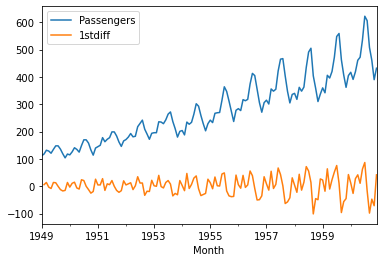

In [5]:
df.plot()

# not quite stationary because seasonality present, varaitation is increasing over time

<AxesSubplot:xlabel='Month'>

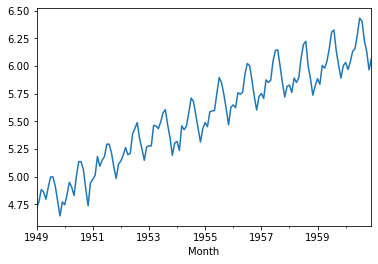

In [6]:
# Log of Passengers column

df['LogPassengers'] = np.log(df['Passengers'])
df['LogPassengers'].plot()

# values don't seem to be growing as rapidly
# amplitude of cycles looks more constant

In [7]:
from statsmodels.tsa.arima_model import ARIMA

# set index frequency to month
# split data into trainig/test using last 12 month of dataset as test set

df.index.freq = 'MS'

Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated an

<AxesSubplot:xlabel='Month'>

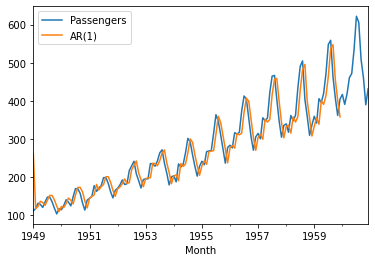

In [8]:
# test AR(1) model --> current value in TS depends linearly on just previous value --> ARIMA(1, 0, 0)
arima = ARIMA(train['Passengers'], order=(1, 0, 0))
arima_result = arima.fit() # return arima resutl object does not return model as scikit learn
# arima.predict to obtain training prediction --> new column AR(1)
df.loc[:-Ntest, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])

# plot AR(1) and original dataset to see how well our model fits with data
df[['Passengers', 'AR(1)']].plot()

# kind of delayed behaviour as Holt-Winters when misspecified
# seems best can do copy previous value

C:\Users\Emilie Berger\anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


<AxesSubplot:xlabel='Month'>

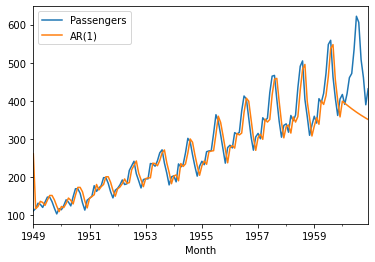

In [9]:
# grab test set prediction --> by calling arima_result.forecast
# return forecast with std error and ci unlike holt-winters

forecast, stderr, confint = arima_result.forecast(Ntest)
df.loc[-Ntest:, 'AR(1)'] = forecast

df[['Passengers', 'AR(1)']].plot()

# model not very good
# doesn't even get that upwards supposed to go upwards --> wrong direction (even Naive forecast'd be better)

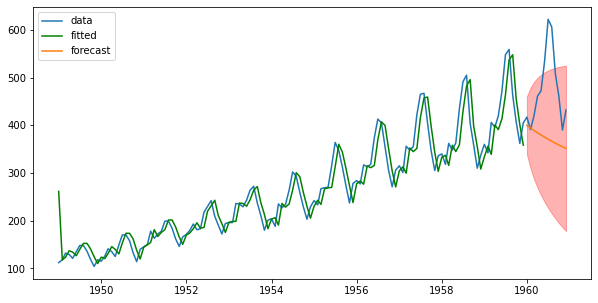

In [10]:
# function to plot fitted value of an ARIMA model
# along with forecast and ci
# helpfu so we don't have to write it again

# set size of the plot; 10 cols,  rows
# plot function passing in passengers col of df 
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df['Passengers'], label='data')
    
    # plot curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')
    
    # forecast test set
    forecast, stderr, cofint = result.forecast(Ntest)
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                   cofint[:, 0], cofint[:, 1], \
                   color='red', alpha=0.3)
    ax.legend() # for our legend to show on our plot
    
plot_fit_and_forecast(arima_result)


# AR(1) forecast again, not very good...

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


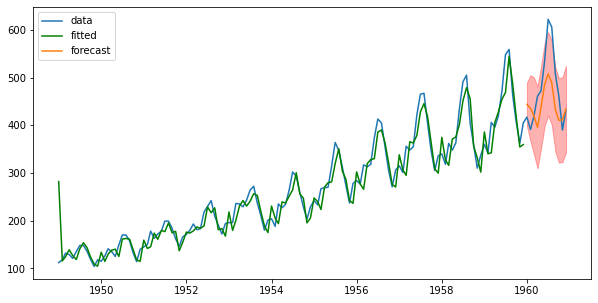

In [11]:
# if bad models, add more input --> AR(10) model

arima = ARIMA(train['Passengers'], order=(10, 0, 0)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

# much better job, learning to anticipate the pattern, periodic
# but seems to underestimate true value, significantly

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


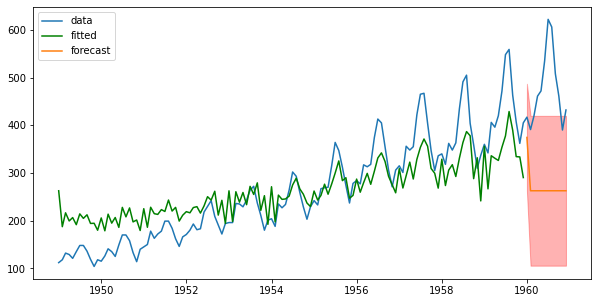

In [12]:
# test MA(1) model

arima = ARIMA(train['Passengers'], order=(0, 0, 1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

# pretty bad, even worse than AR(1)
# MA model expected forecast always constant value, so intuitively not right choice

In [13]:
# investigate using LogPassengers

df['Log1stDiff'] = df['LogPassengers'].diff()
df[['Passengers', 'LogPassengers', 'Log1stDiff']].head()

,Passengers,LogPassengers,Log1stDiff
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


<AxesSubplot:xlabel='Month'>

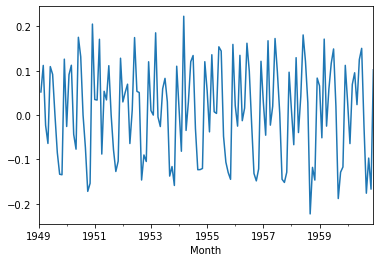

In [14]:
df['Log1stDiff'].plot()

# expected behaviour, don't seem to grow that much overtime

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated an

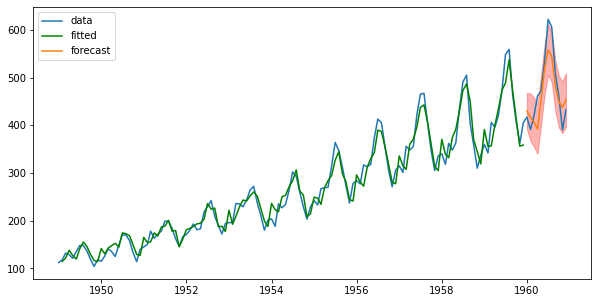

In [15]:
# fit in new model on non-log passengers
# differencing = good <-- remove the trend
# Arima(8, 1, 1)  

# p = 8 since it seems regression on more pass values helps
# d = 1 since as we saw remove ts trend
# q = 1 for good measure to have full arima model with all the components

arima = ARIMA(train['Passengers'], order=(8, 1, 1))
arima_result_811 = arima.fit()

# new function  because data been differenced
# difference removes 1st row from dataset
# last value can't exist
# plot_fit_and_forecast(arima_result_811) 
# --> ValueError: x and y must have same first dimension, but have shapes (132,) and (131,)

# takes in 3 arg, result, d represents 1st row in difference existing ts, col will tell us the column
def plot_fit_and_forecast_int(result, d, col='Passengers'): 
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df[col], label='data') # now we index df using col arg rather than fixed col name
    
    # plot the curve fitted on train set
    # predict function to be explicit about indices
    # necessary to get values back instead of original ts
    # d instead of 0
    # 'levels' return model prediction in terms of original ts rather than diff.
    train_pred = result.predict(start=train.index[d], end=train.index[-1], \
                               typ='levels')
    
    ax.plot(train.index[d:], train_pred, color='green', label='fitted')
    
    # forecast the test set (same as before)
    forecast, stderr, cofint = result.forecast(Ntest)
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                   cofint[:, 0], cofint[:, 1], \
                   color='red', alpha=0.3)
    ax.legend() # for our legend to show on our plot
    
    
plot_fit_and_forecast_int(arima_result_811, 1) 
    
# pretty well innit? ;)
# underestimate peak, overestimate chart?

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


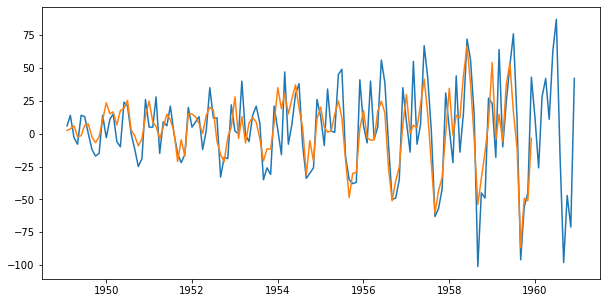

In [16]:
# create function plotting fit of the model on difference series
# statsmodel actually takes predictions on difference series internally in order to show final forecast
# ... and acumulating them to show final non-difference forecast
# --> plot to look at to know how well ARMA part of the model fits (part containg all the parameters)

def plot_difference(result, d, col='Passengers'): # same as before
    train_pred = result.predict(start=train.index[d], end=train.index[-1]) # no typ='levels', leave as default --> returns what got fitted with arma model
    # or simply train_pred = result.fittedvalues
    diff = df[col].diff() # df difference, could difference d times but d = 1
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(diff, label='true 1st difference')
    ax.plot(train_pred, label='fitted 1st difference')
    
plot_difference(arima_result_811, 1)

# results = pretty ood
# Dataset = non-stationary, variance increasing overtime
# model seems to capture this at least for in-sample data

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated an

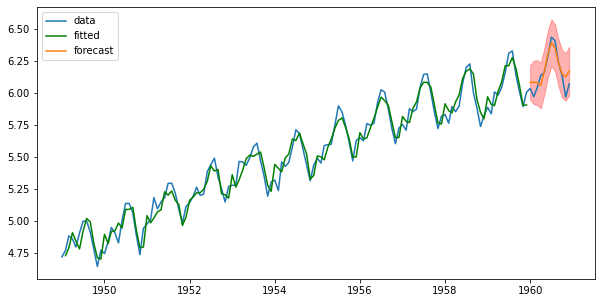

In [17]:
# fit in ARIMA model with same p, d, q values 
# but this time log dataset
# as usual --> fit and plot result

arima = ARIMA(train['LogPassengers'], order=(8,1,1))
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPassengers')

# our model does pretty well, maybe even better than last

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


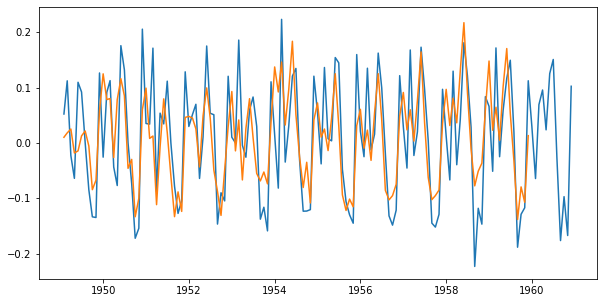

In [18]:
# plot difference function on LogPassengers model

plot_difference(arima_result_log811, 1, col='LogPassengers')

# again fits pretty well
# this time, variance does not increase over time --> seems model has an easier time learning

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated an

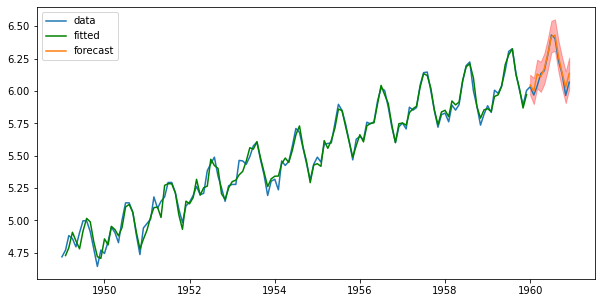

In [19]:
# just out of curiosity...
# fit other model on LogPassenger Dataset with p=12 and q=0
# 12 = lenght of period, data of all 12 month of past year to make prediction

arima = ARIMA(train['LogPassengers'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPassengers')

# takes a while because, algo is not closed form of equation

# seems to be best model so far

In [21]:
# to really know how well those models performed
# useful to look at metrics
# --> function

# takes in 2 arg, arima result object, flag to tell if the model was fitted on log or non-log passengers
# call forecast to get it, get it?! ;)
# check is logged
# if true exponentiate forecast to put data back in original scale
# assign passengers col of test df to a variable t
# assign forecast to a variable y
# usual rmse formula and return its value

def rmse(result, is_logged):
    forecast, stderr, cofint = result.forecast(Ntest)
    if is_logged:
        forecast = np.exp(forecast)
        
    t = test['Passengers']
    y = forecast
    return np.sqrt(np.mean((t - y)**2))

print("ARIMA(8, 1, 1):", rmse(arima_result_811, False))
print("ARIMA(8, 1, 1) logged:", rmse(arima_result_log811, True))
print("ARIMA(8, 1, 1) logged:", rmse(arima_result_log1210, True))

# last model more accurate by far

ARIMA(8, 1, 1): 38.550664083984664
ARIMA(8, 1, 1) logged: 32.22414095412062
ARIMA(8, 1, 1) logged: 18.61212487608406
